In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

end = '2016-04-03'
start = '2015-04-03'

trip_temps = calc_temps(start,end)

print(f'The min, avg and max temperatures between {end} and {start} are:\
{trip_temps[0][0]}, {trip_temps[0][1]} and {trip_temps[0][2]}')

The min, avg and max temperatures between 2016-04-03 and 2015-04-03 are:56.0, 74.28028704094555 and 86.0


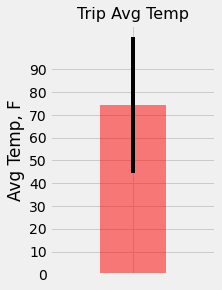

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

temp = trip_temps[0][1]
x_axis = [1]
yerr = trip_temps[0][2] - trip_temps[0][0]
ytick_s = range(0,100,10)
fig = plt.figure(figsize = (3,4))

plt.bar(x_axis, temp, color='r', alpha=0.5, align="center", yerr = yerr)
tick_locations = [value for value in x_axis]
plt.xticks(tick_locations, "")
plt.xlim(0,2)

plt.yticks(ytick_s)
plt.tight_layout()
plt.title("Trip Avg Temp", fontsize = 16)
plt.ylabel("Avg Temp, F")
fig.savefig('Images/temperatures.png')

### Daily Rainfall Average

In [12]:
# Take another look at Measurement keys
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2729585f048>,
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01'}

In [13]:
# Take another look at Station keys
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x2729585f550>,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [14]:
# Perform a join of the two data sets to incorporate long, lat data
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel = [Measurement.station, Station.name, Measurement.tobs, Measurement.prcp, Station.longitude,
       Station.latitude, Station.elevation]

same_station = session.query(*sel, func.sum(Measurement.prcp)).filter(Measurement.station == Station.station).\
                filter(Measurement.date >= start).filter(Measurement.date <= end).\
                group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

same_station

[('USC00517948',
  'PEARL CITY, HI US',
  78.0,
  0.04,
  -157.9751,
  21.3934,
  11.9,
  3.3000000000000003),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  77.0,
  0.0,
  -157.71139,
  21.33556,
  19.5,
  51.48999999999999),
 ('USC00519397',
  'WAIKIKI 717.2, HI US',
  72.0,
  0.0,
  -157.8168,
  21.2716,
  3.0,
  16.05999999999999),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  74.0,
  0.0,
  -157.84888999999998,
  21.45167,
  32.9,
  81.48999999999995),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  77.0,
  0.0,
  -157.8374,
  21.5213,
  7.0,
  42.18999999999998),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  74.0,
  0.0,
  -157.8015,
  21.4234,
  14.6,
  53.7),
 ('USC00511918',
  'HONOLULU OBSERVATORY 702.2, HI US',
  77.0,
  0.0,
  -157.9992,
  21.3152,
  0.9,
  4.620000000000001),
 ('USC00518838',
  'UPPER WAHIAWA 874.3, HI US',
  72.0,
  None,
  -158.0111,
  21.4992,
  306.6,
  0.0),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  70.0,
  None,
  -

In [15]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [16]:
# calculate the daily normals for your trip

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

start = dt.datetime.strptime(start_date,'%Y-%m-%d')
end = dt.datetime.strptime(end_date,'%Y-%m-%d')

# Use the start and end date to create a range of dates

dates = [(start + dt.timedelta(days=x)).strftime('%m-%d') for x in range(0, (end-start).days)]

normals = [daily_normals(date) for date in dates]
normals

[[(67.0, 75.54, 83.0)],
 [(68.0, 75.60377358490567, 84.0)],
 [(70.0, 76.61111111111111, 85.0)],
 [(69.0, 76.71153846153847, 84.0)],
 [(69.0, 76.14814814814815, 82.0)],
 [(67.0, 76.25, 83.0)]]

In [17]:
# Assign temperature values to iondividual variables to load into a dataframe
tmin = []
tavg = []
tmax = []
for index in range(len(normals)):
    tmin.append(normals[index][0][0])
    tavg.append(normals[index][0][1])
    tmax.append(normals[index][0][2])

In [18]:
# Create dataframe with trip dates and temperature data
# First create format for trip_dates
trip_dates = [(start + dt.timedelta(days=x)).strftime('%Y-%m-%d') for x in range(0, (end-start).days)]

trip_df = pd.DataFrame({'Trip Dates': trip_dates,
                      'Min Temps': tmin,
                      'Avg Temps': tavg,
                      'Max Temps': tmax}).set_index('Trip Dates')
trip_df

,Min Temps,Avg Temps,Max Temps
Trip Dates,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0


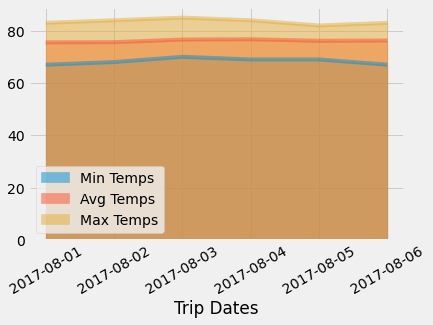

In [19]:
# Plot data via area plot with stacked = False

trip_df.plot.area(stacked = False)
plt.xticks(rotation = 30)
plt.savefig('Images/trip_avgs.png')

## Close Session

In [20]:
session.close()